# 1st case => m=4  (8 Pupils) and [alpha_min,alpha_max]=[0.25,0.75]

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/var/folders/qc/cl66n0gn1cqgckzb18klf0zw0000gn/T/ipykernel_63703/1476718574.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  denominator, _ = quad(psi, 0, np.inf)


Optimal values of a_k: [0.11748942 0.11872865 0.11817635 0.11818388 0.11815389 0.11806872
 0.11867326 0.11839145]
Optimal values of u_k: [-3.5879538  -2.5014852  -1.50350217 -0.50996199  0.5110241   1.50329654
  2.50366547  3.58863948]
Dynamic: 0.727824788365858
Central flux: 0.8635135598287288


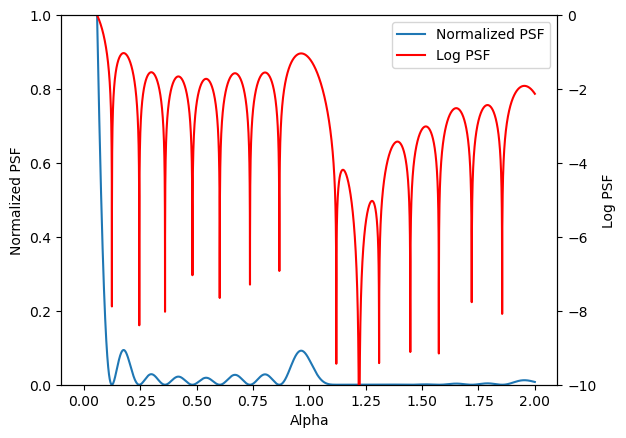

+-----+------------+------------+--------------------+
|   k |        a_k |        u_k | u_k - u_{k-1}      |
+=====+============+============+====================+
|   1 | 0.11748942 | 0.51102410 | -                  |
+-----+------------+------------+--------------------+
|   2 | 0.11872865 | 1.50329654 | 0.9922724347420337 |
+-----+------------+------------+--------------------+
|   3 | 0.11817635 | 2.50366547 | 1.0003689389681545 |
+-----+------------+------------+--------------------+
|   4 | 0.11818388 | 3.58863948 | 1.084974007817344  |
+-----+------------+------------+--------------------+


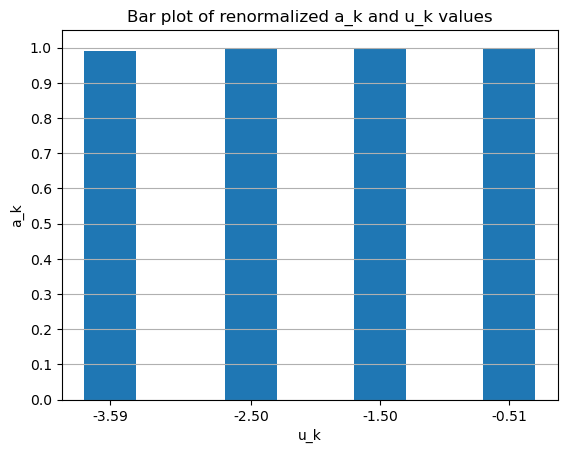

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import j1
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tabulate import tabulate

# Objective function
def objective(x, d, alpha_values):
    n = len(x) // 2
    a = x[:n]
    u = x[n:-1]
    t = x[-1]
    bessel_term = np.array([j1(np.pi * alpha) / alpha for alpha in alpha_values])
    sum_term = np.array([np.sum(a * np.cos(2 * np.pi * u[:, np.newaxis] / d * alpha)) for alpha in alpha_values])
    diff = bessel_term * sum_term - t
    return np.max(np.abs(diff))

# Constraints
def constraints(x, d, n):
    a = x[:n]
    u = x[n:-1]
    constraint_1 = [u[k+1] - u[k] - d for k in range(n-1)]
    constraint_2 = [np.sum(a) - 1]
    constraint_3 = [-a[k] for k in range(n)]
    return constraint_1 + constraint_2 + constraint_3

# Central flux computation
def central_flux(a, u, d, alpha_min, alpha_max):
    def psi(alpha):
        bessel_term = j1(np.pi * alpha) / alpha
        sum_term = np.sum(a * np.cos(2 * np.pi * u / d * alpha))
        return (bessel_term * sum_term)**2

    numerator, _ = quad(psi, 0, alpha_min)
    denominator, _ = quad(psi, 0, np.inf)
    return numerator / denominator

# Optimization
def optimize_psf(a_init, u_init, d, alpha_min, alpha_max, n, q):
    alpha_values = np.linspace(alpha_min, alpha_max, q)

    # Minimize the objective function
    x0 = np.concatenate((a_init, u_init, [0]))
    result = minimize(lambda x: objective(x, d, alpha_values),
                      x0=x0,
                      constraints={'type': 'ineq', 'fun': lambda x: constraints(x, d, n)},
                      tol=1e-10)
    return result

# Starting point strategy
def starting_point_strategy(m, d, alpha_min, alpha_max):
    n = 2 * m
    u_init = np.array([(k - 0.5) * d / (alpha_min + alpha_max) for k in range(1, m + 1)])
    u_init = np.concatenate((-u_init[::-1], u_init))

    a_init = np.ones(n)
    a_init /= np.sum(a_init)

    return a_init, u_init

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1

def normalized_psf(alpha, a, u, d):
    bessel_term = j1(np.pi * alpha) / alpha
    sum_term = np.sum(a * np.cos(2 * np.pi * u / d * alpha))
    return (bessel_term * sum_term)**2

def plot_psf(a_optimal, u_optimal, d):
    alpha_values = np.linspace(0.000001, 2, 10000)
    psf_values = [normalized_psf(alpha, a_optimal, u_optimal, d) for alpha in alpha_values]
    log_psf_values = np.log10(psf_values)

    fig, ax1 = plt.subplots()

    ax1.plot(alpha_values, psf_values, label='Normalized PSF')
    ax1.set_xlabel('Alpha')
    ax1.set_ylabel('Normalized PSF')
    ax1.set_ylim(0, 1)

    ax2 = ax1.twinx()
    ax2.plot(alpha_values, log_psf_values, 'r', label='Log PSF')
    ax2.set_ylabel('Log PSF')
    ax2.set_ylim(-10, 0)

    fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
    plt.show()

def print_table(a_values, u_values):
    k_values = range(1, len(a_values) + 1)
    u_diff_values = [u_values[i] - u_values[i - 1] for i in range(1, len(u_values))]
    u_diff_values.insert(0, "-")  # Add a dash for the first entry

    table_data = zip(k_values, a_values, u_values, u_diff_values)
    table_headers = ["k", "a_k", "u_k", "u_k - u_{k-1}"]

    print(tabulate(table_data, headers=table_headers, floatfmt=".8f", tablefmt="grid"))
    
def plot_bar_graph(a_optimal, u_optimal):
    # Renormalize a_k values
    a_optimal_renormalized = a_optimal / np.max(a_optimal)

    fig, ax = plt.subplots()
    bar_width = 0.4
    x = np.arange(1, len(a_optimal_renormalized) // 2 + 1)
    ax.bar(u_optimal[:len(u_optimal)//2], a_optimal_renormalized[:len(a_optimal_renormalized)//2], width=bar_width)
    ax.set_xlabel('u_k')
    ax.set_ylabel('a_k')
    ax.set_title('Bar plot of renormalized a_k and u_k values')
    plt.xticks(u_optimal[:len(u_optimal)//2], [f"{u:.2f}" for u in u_optimal[:len(u_optimal)//2]])
    plt.yticks(np.linspace(0, 1, 11))
    plt.grid(axis='y')
    plt.show()


def main():
    m = 4
    d = 1
    alpha_min = 0.25
    alpha_max = 0.75
    n = 2 * m
    q = 10 * n

    a_init, u_init = starting_point_strategy(m, d, alpha_min, alpha_max)

    result = optimize_psf(a_init, u_init, d, alpha_min, alpha_max, n, q)
    x_optimal = result.x
    a_optimal = x_optimal[:n]
    u_optimal = x_optimal[n:-1]
    
     # Considering only the second half of u_k values and sorting them in ascending order
    u_optimal_positive = np.sort(u_optimal[m:])
    
    # Considering only the second half of a_k values
    a_optimal_positive = a_optimal[m:]



    dynamic = 1 / result.fun
    central_flux_value = central_flux(a_optimal, u_optimal, d, alpha_min, alpha_max)

    print("Optimal values of a_k:", a_optimal)
    print("Optimal values of u_k:", u_optimal)
    print("Dynamic:", dynamic)
    print("Central flux:", central_flux_value)
    plot_psf(a_optimal, u_optimal, d)
    print_table(a_optimal[:4], u_optimal[4:])
    plot_bar_graph(a_optimal, u_optimal)


if __name__ == "__main__":
    main()


# 2nd case => m=4  (8 Pupils) and [alpha_min,alpha_max]=[0.4,0.6]

/var/folders/qc/cl66n0gn1cqgckzb18klf0zw0000gn/T/ipykernel_63703/3895313831.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  denominator, _ = quad(psi, 0, np.inf)


Optimal values of a_k: [0.07301724 0.13701626 0.11559308 0.05393108 0.08458299 0.08053608
 0.1235771  0.11602657]
Optimal values of u_k: [-4.0826388  -3.08191505 -2.1155288  -1.0881731  -0.0835721   0.91825599
  1.92737158  3.01946993]
Dynamic: 10.290141414107751
Central flux: 0.9045444127916401


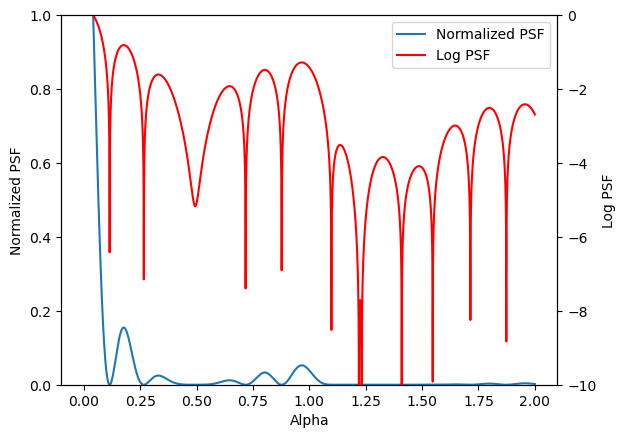

+-----+------------+-------------+--------------------+
|   k |        a_k |         u_k | u_k - u_{k-1}      |
+=====+============+=============+====================+
|   1 | 0.07301724 | -0.08357210 | -                  |
+-----+------------+-------------+--------------------+
|   2 | 0.13701626 |  0.91825599 | 1.0018280976187244 |
+-----+------------+-------------+--------------------+
|   3 | 0.11559308 |  1.92737158 | 1.0091155894845163 |
+-----+------------+-------------+--------------------+
|   4 | 0.05393108 |  3.01946993 | 1.0920983410120555 |
+-----+------------+-------------+--------------------+


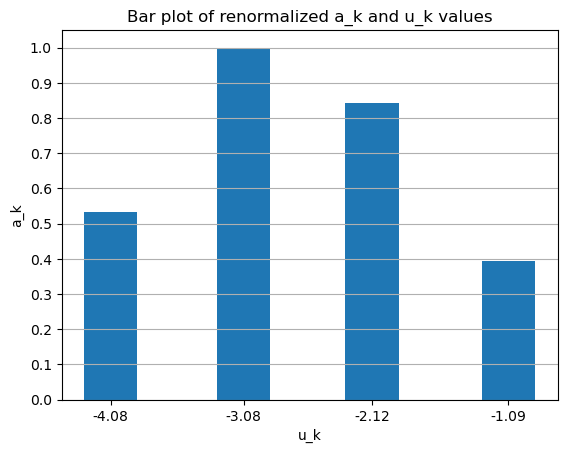

In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import j1
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tabulate import tabulate

# Objective function
def objective(x, d, alpha_values):
    n = len(x) // 2
    a = x[:n]
    u = x[n:-1]
    t = x[-1]
    bessel_term = np.array([j1(np.pi * alpha) / alpha for alpha in alpha_values])
    sum_term = np.array([np.sum(a * np.cos(2 * np.pi * u[:, np.newaxis] / d * alpha)) for alpha in alpha_values])
    diff = bessel_term * sum_term - t
    return np.max(np.abs(diff))

# Constraints
def constraints(x, d, n):
    a = x[:n]
    u = x[n:-1]
    constraint_1 = [u[k+1] - u[k] - d for k in range(n-1)]
    constraint_2 = [np.sum(a) - 1]
    constraint_3 = [-a[k] for k in range(n)]
    return constraint_1 + constraint_2 + constraint_3

# Central flux computation
def central_flux(a, u, d, alpha_min, alpha_max):
    def psi(alpha):
        bessel_term = j1(np.pi * alpha) / alpha
        sum_term = np.sum(a * np.cos(2 * np.pi * u / d * alpha))
        return (bessel_term * sum_term)**2

    numerator, _ = quad(psi, 0, alpha_min)
    denominator, _ = quad(psi, 0, np.inf)
    return numerator / denominator

# Optimization
def optimize_psf(a_init, u_init, d, alpha_min, alpha_max, n, q):
    alpha_values = np.linspace(alpha_min, alpha_max, q)

    # Minimize the objective function
    x0 = np.concatenate((a_init, u_init, [0]))
    result = minimize(lambda x: objective(x, d, alpha_values),
                      x0=x0,
                      constraints={'type': 'ineq', 'fun': lambda x: constraints(x, d, n)},
                      tol=1e-10)
    return result

# Starting point strategy
def starting_point_strategy(m, d, alpha_min, alpha_max):
    n = 2 * m
    u_init = np.array([(k - 0.5) * d / (alpha_min + alpha_max) for k in range(1, m + 1)])
    u_init = np.concatenate((-u_init[::-1], u_init))

    a_init = np.ones(n)
    a_init /= np.sum(a_init)

    return a_init, u_init

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1

def normalized_psf(alpha, a, u, d):
    bessel_term = j1(np.pi * alpha) / alpha
    sum_term = np.sum(a * np.cos(2 * np.pi * u / d * alpha))
    return (bessel_term * sum_term)**2

def plot_psf(a_optimal, u_optimal, d):
    alpha_values = np.linspace(0.000001, 2, 10000)
    psf_values = [normalized_psf(alpha, a_optimal, u_optimal, d) for alpha in alpha_values]
    log_psf_values = np.log10(psf_values)

    fig, ax1 = plt.subplots()

    ax1.plot(alpha_values, psf_values, label='Normalized PSF')
    ax1.set_xlabel('Alpha')
    ax1.set_ylabel('Normalized PSF')
    ax1.set_ylim(0, 1)

    ax2 = ax1.twinx()
    ax2.plot(alpha_values, log_psf_values, 'r', label='Log PSF')
    ax2.set_ylabel('Log PSF')
    ax2.set_ylim(-10, 0)

    fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
    plt.show()

def print_table(a_values, u_values):
    k_values = range(1, len(a_values) + 1)
    u_diff_values = [u_values[i] - u_values[i - 1] for i in range(1, len(u_values))]
    u_diff_values.insert(0, "-")  # Add a dash for the first entry

    table_data = zip(k_values, a_values, u_values, u_diff_values)
    table_headers = ["k", "a_k", "u_k", "u_k - u_{k-1}"]

    print(tabulate(table_data, headers=table_headers, floatfmt=".8f", tablefmt="grid"))
    
def plot_bar_graph(a_optimal, u_optimal):
    # Renormalize a_k values
    a_optimal_renormalized = a_optimal / np.max(a_optimal)

    fig, ax = plt.subplots()
    bar_width = 0.4
    x = np.arange(1, len(a_optimal_renormalized) // 2 + 1)
    ax.bar(u_optimal[:len(u_optimal)//2], a_optimal_renormalized[:len(a_optimal_renormalized)//2], width=bar_width)
    ax.set_xlabel('u_k')
    ax.set_ylabel('a_k')
    ax.set_title('Bar plot of renormalized a_k and u_k values')
    plt.xticks(u_optimal[:len(u_optimal)//2], [f"{u:.2f}" for u in u_optimal[:len(u_optimal)//2]])
    plt.yticks(np.linspace(0, 1, 11))
    plt.grid(axis='y')
    plt.show()


def main():
    m = 4
    d = 1.001
    alpha_min = 0.4
    alpha_max = 0.6
    n = 2 * m
    q = 10 * n

    a_init, u_init = starting_point_strategy(m, d, alpha_min, alpha_max)

    result = optimize_psf(a_init, u_init, d, alpha_min, alpha_max, n, q)
    x_optimal = result.x
    a_optimal = x_optimal[:n]
    u_optimal = x_optimal[n:-1]
    
     # Considering only the second half of u_k values and sorting them in ascending order
    u_optimal_positive = np.sort(u_optimal[m:])
    
    # Considering only the second half of a_k values
    a_optimal_positive = a_optimal[m:]



    dynamic = 1 / result.fun
    central_flux_value = central_flux(a_optimal, u_optimal, d, alpha_min, alpha_max)

    print("Optimal values of a_k:", a_optimal)
    print("Optimal values of u_k:", u_optimal)
    print("Dynamic:", dynamic)
    print("Central flux:", central_flux_value)
    plot_psf(a_optimal, u_optimal, d)
    print_table(a_optimal[:4], u_optimal[4:])
    plot_bar_graph(a_optimal, u_optimal)


if __name__ == "__main__":
    main()


# 3rd case => m=4  (8 Pupils) and [alpha_min,alpha_max]=[0.15,0.85] 

/var/folders/qc/cl66n0gn1cqgckzb18klf0zw0000gn/T/ipykernel_63703/1121550113.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  denominator, _ = quad(psi, 0, np.inf)


Optimal values of a_k: [0.06474477 0.08592511 0.08406073 0.07044488 0.09450025 0.07951576
 0.08338714 0.07241683]
Optimal values of u_k: [-5.0662277  -3.17001423 -1.90083763 -0.85099288  0.37303218  1.37403218
  2.44736806  4.03130573]
Dynamic: 1.6394503730749206
Central flux: 0.9548497267723799


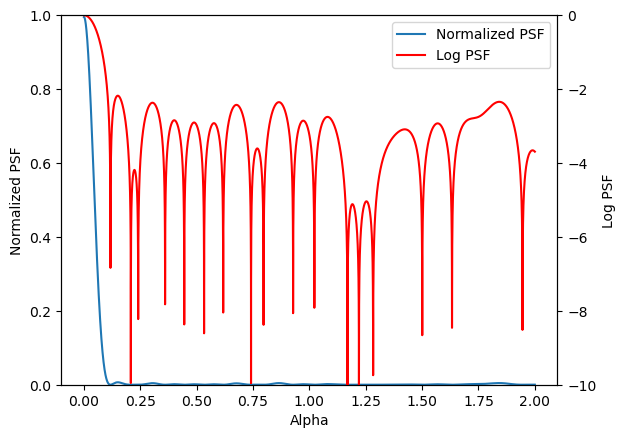

+-----+------------+------------+--------------------+
|   k |        a_k |        u_k | u_k - u_{k-1}      |
+=====+============+============+====================+
|   1 | 0.06474477 | 0.37303218 | -                  |
+-----+------------+------------+--------------------+
|   2 | 0.08592511 | 1.37403218 | 1.00100000000168   |
+-----+------------+------------+--------------------+
|   3 | 0.08406073 | 2.44736806 | 1.0733358747385937 |
+-----+------------+------------+--------------------+
|   4 | 0.07044488 | 4.03130573 | 1.583937668334476  |
+-----+------------+------------+--------------------+


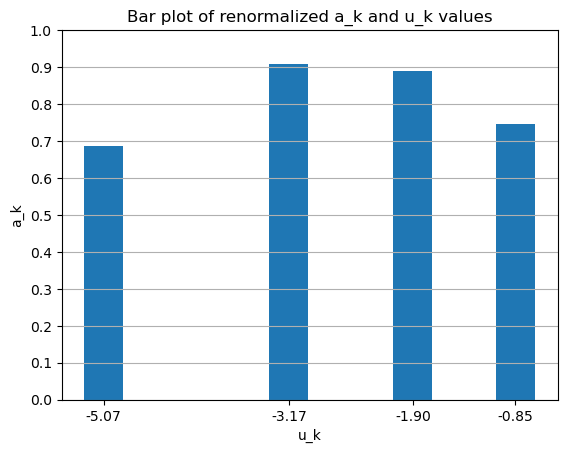

In [3]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import j1
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tabulate import tabulate

# Objective function
def objective(x, d, alpha_values):
    n = len(x) // 2
    a = x[:n]
    u = x[n:-1]
    t = x[-1]
    bessel_term = np.array([j1(np.pi * alpha) / alpha for alpha in alpha_values])
    sum_term = np.array([np.sum(a * np.cos(2 * np.pi * u[:, np.newaxis] / d * alpha)) for alpha in alpha_values])
    diff = bessel_term * sum_term - t
    return np.max(np.abs(diff))

# Constraints
def constraints(x, d, n):
    a = x[:n]
    u = x[n:-1]
    constraint_1 = [u[k+1] - u[k] - d for k in range(n-1)]
    constraint_2 = [np.sum(a) - 1]
    constraint_3 = [-a[k] for k in range(n)]
    return constraint_1 + constraint_2 + constraint_3

# Central flux computation
def central_flux(a, u, d, alpha_min, alpha_max):
    def psi(alpha):
        bessel_term = j1(np.pi * alpha) / alpha
        sum_term = np.sum(a * np.cos(2 * np.pi * u / d * alpha))
        return (bessel_term * sum_term)**2

    numerator, _ = quad(psi, 0, alpha_min)
    denominator, _ = quad(psi, 0, np.inf)
    return numerator / denominator

# Optimization
def optimize_psf(a_init, u_init, d, alpha_min, alpha_max, n, q):
    alpha_values = np.linspace(alpha_min, alpha_max, q)

    # Minimize the objective function
    x0 = np.concatenate((a_init, u_init, [0]))
    result = minimize(lambda x: objective(x, d, alpha_values),
                      x0=x0,
                      constraints={'type': 'ineq', 'fun': lambda x: constraints(x, d, n)},
                      tol=1e-10)
    return result

# Starting point strategy
def starting_point_strategy(m, d, alpha_min, alpha_max):
    n = 2 * m
    u_init = np.array([(k - 0.5) * d / (alpha_min + alpha_max) for k in range(1, m + 1)])
    u_init = np.concatenate((-u_init[::-1], u_init))

    a_init = np.ones(n)
    a_init /= np.sum(a_init)

    return a_init, u_init

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1

def normalized_psf(alpha, a, u, d):
    bessel_term = j1(np.pi * alpha) / alpha
    sum_term = np.sum(a * np.cos(2 * np.pi * u / d * alpha))
    return (bessel_term * sum_term)**2

def plot_psf(a_optimal, u_optimal, d):
    alpha_values = np.linspace(0.000001, 2, 10000)
    psf_values = [normalized_psf(alpha, a_optimal, u_optimal, d) for alpha in alpha_values]
    log_psf_values = np.log10(psf_values)

    fig, ax1 = plt.subplots()

    ax1.plot(alpha_values, psf_values, label='Normalized PSF')
    ax1.set_xlabel('Alpha')
    ax1.set_ylabel('Normalized PSF')
    ax1.set_ylim(0, 1)

    ax2 = ax1.twinx()
    ax2.plot(alpha_values, log_psf_values, 'r', label='Log PSF')
    ax2.set_ylabel('Log PSF')
    ax2.set_ylim(-10, 0)

    fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
    plt.show()

def print_table(a_values, u_values):
    k_values = range(1, len(a_values) + 1)
    u_diff_values = [u_values[i] - u_values[i - 1] for i in range(1, len(u_values))]
    u_diff_values.insert(0, "-")  # Add a dash for the first entry

    table_data = zip(k_values, a_values, u_values, u_diff_values)
    table_headers = ["k", "a_k", "u_k", "u_k - u_{k-1}"]

    print(tabulate(table_data, headers=table_headers, floatfmt=".8f", tablefmt="grid"))
    
def plot_bar_graph(a_optimal, u_optimal):
    # Renormalize a_k values
    a_optimal_renormalized = a_optimal / np.max(a_optimal)

    fig, ax = plt.subplots()
    bar_width = 0.4
    x = np.arange(1, len(a_optimal_renormalized) // 2 + 1)
    ax.bar(u_optimal[:len(u_optimal)//2], a_optimal_renormalized[:len(a_optimal_renormalized)//2], width=bar_width)
    ax.set_xlabel('u_k')
    ax.set_ylabel('a_k')
    ax.set_title('Bar plot of renormalized a_k and u_k values')
    plt.xticks(u_optimal[:len(u_optimal)//2], [f"{u:.2f}" for u in u_optimal[:len(u_optimal)//2]])
    plt.yticks(np.linspace(0, 1, 11))
    plt.grid(axis='y')
    plt.show()


def main():
    m = 4
    d = 1.001
    alpha_min = 0.15
    alpha_max = 0.85
    n = 2 * m
    q = 10 * n

    a_init, u_init = starting_point_strategy(m, d, alpha_min, alpha_max)

    result = optimize_psf(a_init, u_init, d, alpha_min, alpha_max, n, q)
    x_optimal = result.x
    a_optimal = x_optimal[:n]
    u_optimal = x_optimal[n:-1]
    
     # Considering only the second half of u_k values and sorting them in ascending order
    u_optimal_positive = np.sort(u_optimal[m:])
    
    # Considering only the second half of a_k values
    a_optimal_positive = a_optimal[m:]



    dynamic = 1 / result.fun
    central_flux_value = central_flux(a_optimal, u_optimal, d, alpha_min, alpha_max)

    print("Optimal values of a_k:", a_optimal)
    print("Optimal values of u_k:", u_optimal)
    print("Dynamic:", dynamic)
    print("Central flux:", central_flux_value)
    plot_psf(a_optimal, u_optimal, d)
    print_table(a_optimal[:4], u_optimal[4:])
    plot_bar_graph(a_optimal, u_optimal)


if __name__ == "__main__":
    main()


# 4th case => m=4  (8 Pupils) and [alpha_min,alpha_max]=[0.05,0.45]

/var/folders/qc/cl66n0gn1cqgckzb18klf0zw0000gn/T/ipykernel_63703/3619787897.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  denominator, _ = quad(psi, 0, np.inf)


Optimal values of a_k: [0.13162542 0.10824471 0.10762936 0.10750321 0.10915011 0.10703431
 0.10874216 0.1070103 ]
Optimal values of u_k: [-7.26624098 -5.00645703 -3.02193422 -1.03471432  1.05347508  2.92853097
  4.84215795  7.00872676]
Dynamic: 0.40371570139181195
Central flux: 0.4279528015771165


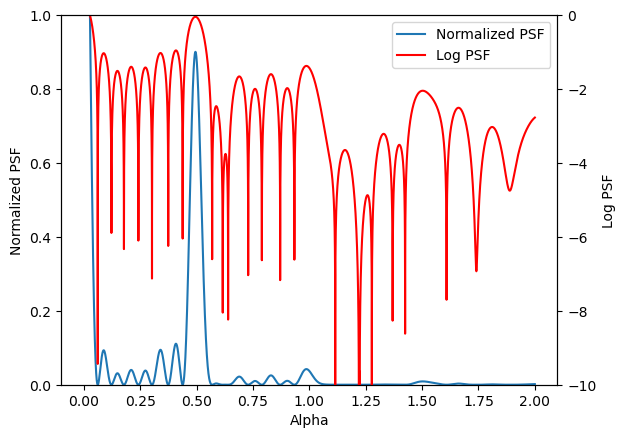

+-----+------------+------------+--------------------+
|   k |        a_k |        u_k | u_k - u_{k-1}      |
+=====+============+============+====================+
|   1 | 0.13162542 | 1.05347508 | -                  |
+-----+------------+------------+--------------------+
|   2 | 0.10824471 | 2.92853097 | 1.875055884022087  |
+-----+------------+------------+--------------------+
|   3 | 0.10762936 | 4.84215795 | 1.9136269858725932 |
+-----+------------+------------+--------------------+
|   4 | 0.10750321 | 7.00872676 | 2.1665688046746325 |
+-----+------------+------------+--------------------+


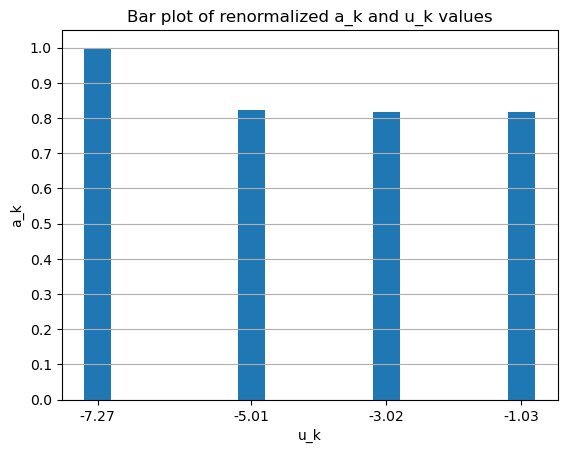

In [4]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import j1
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tabulate import tabulate

# Objective function
def objective(x, d, alpha_values):
    n = len(x) // 2
    a = x[:n]
    u = x[n:-1]
    t = x[-1]
    bessel_term = np.array([j1(np.pi * alpha) / alpha for alpha in alpha_values])
    sum_term = np.array([np.sum(a * np.cos(2 * np.pi * u[:, np.newaxis] / d * alpha)) for alpha in alpha_values])
    diff = bessel_term * sum_term - t
    return np.max(np.abs(diff))

# Constraints
def constraints(x, d, n):
    a = x[:n]
    u = x[n:-1]
    constraint_1 = [u[k+1] - u[k] - d for k in range(n-1)]
    constraint_2 = [np.sum(a) - 1]
    constraint_3 = [-a[k] for k in range(n)]
    return constraint_1 + constraint_2 + constraint_3

# Central flux computation
def central_flux(a, u, d, alpha_min, alpha_max):
    def psi(alpha):
        bessel_term = j1(np.pi * alpha) / alpha
        sum_term = np.sum(a * np.cos(2 * np.pi * u / d * alpha))
        return (bessel_term * sum_term)**2

    numerator, _ = quad(psi, 0, alpha_min)
    denominator, _ = quad(psi, 0, np.inf)
    return numerator / denominator

# Optimization
def optimize_psf(a_init, u_init, d, alpha_min, alpha_max, n, q):
    alpha_values = np.linspace(alpha_min, alpha_max, q)

    # Minimize the objective function
    x0 = np.concatenate((a_init, u_init, [0]))
    result = minimize(lambda x: objective(x, d, alpha_values),
                      x0=x0,
                      constraints={'type': 'ineq', 'fun': lambda x: constraints(x, d, n)},
                      tol=1e-10)
    return result

# Starting point strategy
def starting_point_strategy(m, d, alpha_min, alpha_max):
    n = 2 * m
    u_init = np.array([(k - 0.5) * d / (alpha_min + alpha_max) for k in range(1, m + 1)])
    u_init = np.concatenate((-u_init[::-1], u_init))

    a_init = np.ones(n)
    a_init /= np.sum(a_init)

    return a_init, u_init

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1

def normalized_psf(alpha, a, u, d):
    bessel_term = j1(np.pi * alpha) / alpha
    sum_term = np.sum(a * np.cos(2 * np.pi * u / d * alpha))
    return (bessel_term * sum_term)**2

def plot_psf(a_optimal, u_optimal, d):
    alpha_values = np.linspace(0.000001, 2, 10000)
    psf_values = [normalized_psf(alpha, a_optimal, u_optimal, d) for alpha in alpha_values]
    log_psf_values = np.log10(psf_values)

    fig, ax1 = plt.subplots()

    ax1.plot(alpha_values, psf_values, label='Normalized PSF')
    ax1.set_xlabel('Alpha')
    ax1.set_ylabel('Normalized PSF')
    ax1.set_ylim(0, 1)

    ax2 = ax1.twinx()
    ax2.plot(alpha_values, log_psf_values, 'r', label='Log PSF')
    ax2.set_ylabel('Log PSF')
    ax2.set_ylim(-10, 0)

    fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
    plt.show()

def print_table(a_values, u_values):
    k_values = range(1, len(a_values) + 1)
    u_diff_values = [u_values[i] - u_values[i - 1] for i in range(1, len(u_values))]
    u_diff_values.insert(0, "-")  # Add a dash for the first entry

    table_data = zip(k_values, a_values, u_values, u_diff_values)
    table_headers = ["k", "a_k", "u_k", "u_k - u_{k-1}"]

    print(tabulate(table_data, headers=table_headers, floatfmt=".8f", tablefmt="grid"))
    
def plot_bar_graph(a_optimal, u_optimal):
    # Renormalize a_k values
    a_optimal_renormalized = a_optimal / np.max(a_optimal)

    fig, ax = plt.subplots()
    bar_width = 0.4
    x = np.arange(1, len(a_optimal_renormalized) // 2 + 1)
    ax.bar(u_optimal[:len(u_optimal)//2], a_optimal_renormalized[:len(a_optimal_renormalized)//2], width=bar_width)
    ax.set_xlabel('u_k')
    ax.set_ylabel('a_k')
    ax.set_title('Bar plot of renormalized a_k and u_k values')
    plt.xticks(u_optimal[:len(u_optimal)//2], [f"{u:.2f}" for u in u_optimal[:len(u_optimal)//2]])
    plt.yticks(np.linspace(0, 1, 11))
    plt.grid(axis='y')
    plt.show()


def main():
    m = 4
    d = 1.001
    alpha_min = 0.05
    alpha_max = 0.45
    n = 2 * m
    q = 10 * n

    a_init, u_init = starting_point_strategy(m, d, alpha_min, alpha_max)

    result = optimize_psf(a_init, u_init, d, alpha_min, alpha_max, n, q)
    x_optimal = result.x
    a_optimal = x_optimal[:n]
    u_optimal = x_optimal[n:-1]
    
     # Considering only the second half of u_k values and sorting them in ascending order
    u_optimal_positive = np.sort(u_optimal[m:])
    
    # Considering only the second half of a_k values
    a_optimal_positive = a_optimal[m:]



    dynamic = 1 / result.fun
    central_flux_value = central_flux(a_optimal, u_optimal, d, alpha_min, alpha_max)

    print("Optimal values of a_k:", a_optimal)
    print("Optimal values of u_k:", u_optimal)
    print("Dynamic:", dynamic)
    print("Central flux:", central_flux_value)
    plot_psf(a_optimal, u_optimal, d)
    print_table(a_optimal[:4], u_optimal[4:])
    plot_bar_graph(a_optimal, u_optimal)


if __name__ == "__main__":
    main()


# 5th case => m=4  (8 Pupils) and [alpha_min,alpha_max]=[0.3,0.7]

/var/folders/qc/cl66n0gn1cqgckzb18klf0zw0000gn/T/ipykernel_63703/2159017324.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  denominator, _ = quad(psi, 0, np.inf)


Optimal values of a_k: [0.12492574 0.12492206 0.12492955 0.12492975 0.12492808 0.1249332
 0.12493174 0.12492988]
Optimal values of u_k: [-3.66286382 -2.57497139 -1.57395491 -0.50648287  0.50577659  1.57349652
  2.57498884  3.70659954]
Dynamic: 0.6535824974853955
Central flux: 0.8504794824265309


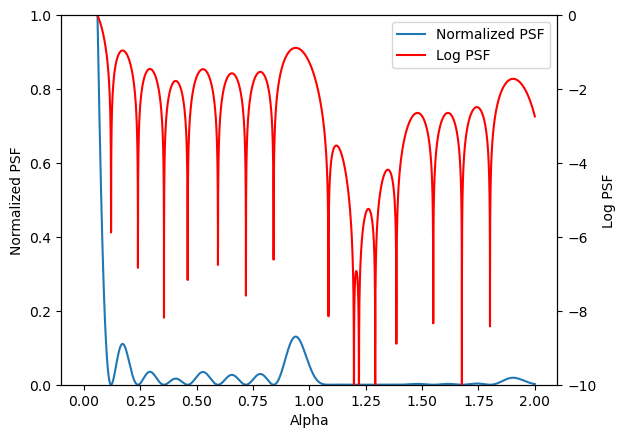

+-----+------------+------------+--------------------+
|   k |        a_k |        u_k | u_k - u_{k-1}      |
+=====+============+============+====================+
|   1 | 0.12492574 | 0.50577659 | -                  |
+-----+------------+------------+--------------------+
|   2 | 0.12492206 | 1.57349652 | 1.0677199333298177 |
+-----+------------+------------+--------------------+
|   3 | 0.12492955 | 2.57498884 | 1.0014923154297521 |
+-----+------------+------------+--------------------+
|   4 | 0.12492975 | 3.70659954 | 1.1316107008204206 |
+-----+------------+------------+--------------------+


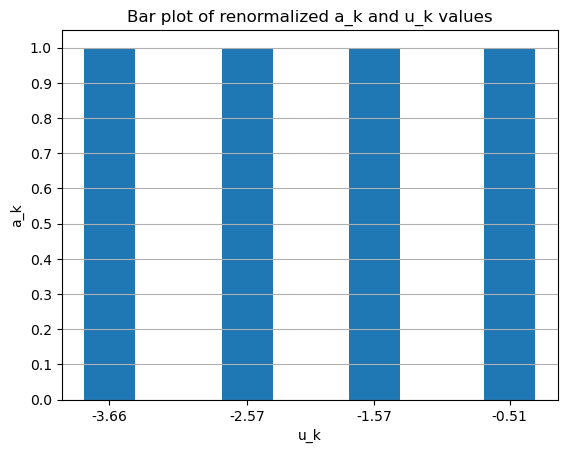

In [5]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import j1
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tabulate import tabulate

# Objective function
def objective(x, d, alpha_values):
    n = len(x) // 2
    a = x[:n]
    u = x[n:-1]
    t = x[-1]
    bessel_term = np.array([j1(np.pi * alpha) / alpha for alpha in alpha_values])
    sum_term = np.array([np.sum(a * np.cos(2 * np.pi * u[:, np.newaxis] / d * alpha)) for alpha in alpha_values])
    diff = bessel_term * sum_term - t
    return np.max(np.abs(diff))

# Constraints
def constraints(x, d, n):
    a = x[:n]
    u = x[n:-1]
    constraint_1 = [u[k+1] - u[k] - d for k in range(n-1)]
    constraint_2 = [np.sum(a) - 1]
    constraint_3 = [-a[k] for k in range(n)]
    return constraint_1 + constraint_2 + constraint_3

# Central flux computation
def central_flux(a, u, d, alpha_min, alpha_max):
    def psi(alpha):
        bessel_term = j1(np.pi * alpha) / alpha
        sum_term = np.sum(a * np.cos(2 * np.pi * u / d * alpha))
        return (bessel_term * sum_term)**2

    numerator, _ = quad(psi, 0, alpha_min)
    denominator, _ = quad(psi, 0, np.inf)
    return numerator / denominator

# Optimization
def optimize_psf(a_init, u_init, d, alpha_min, alpha_max, n, q):
    alpha_values = np.linspace(alpha_min, alpha_max, q)

    # Minimize the objective function
    x0 = np.concatenate((a_init, u_init, [0]))
    result = minimize(lambda x: objective(x, d, alpha_values),
                      x0=x0,
                      constraints={'type': 'ineq', 'fun': lambda x: constraints(x, d, n)},
                      tol=1e-10)
    return result

# Starting point strategy
def starting_point_strategy(m, d, alpha_min, alpha_max):
    n = 2 * m
    u_init = np.array([(k - 0.5) * d / (alpha_min + alpha_max) for k in range(1, m + 1)])
    u_init = np.concatenate((-u_init[::-1], u_init))

    a_init = np.ones(n)
    a_init /= np.sum(a_init)

    return a_init, u_init

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1

def normalized_psf(alpha, a, u, d):
    bessel_term = j1(np.pi * alpha) / alpha
    sum_term = np.sum(a * np.cos(2 * np.pi * u / d * alpha))
    return (bessel_term * sum_term)**2

def plot_psf(a_optimal, u_optimal, d):
    alpha_values = np.linspace(0.000001, 2, 10000)
    psf_values = [normalized_psf(alpha, a_optimal, u_optimal, d) for alpha in alpha_values]
    log_psf_values = np.log10(psf_values)

    fig, ax1 = plt.subplots()

    ax1.plot(alpha_values, psf_values, label='Normalized PSF')
    ax1.set_xlabel('Alpha')
    ax1.set_ylabel('Normalized PSF')
    ax1.set_ylim(0, 1)

    ax2 = ax1.twinx()
    ax2.plot(alpha_values, log_psf_values, 'r', label='Log PSF')
    ax2.set_ylabel('Log PSF')
    ax2.set_ylim(-10, 0)

    fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
    plt.show()

def print_table(a_values, u_values):
    k_values = range(1, len(a_values) + 1)
    u_diff_values = [u_values[i] - u_values[i - 1] for i in range(1, len(u_values))]
    u_diff_values.insert(0, "-")  # Add a dash for the first entry

    table_data = zip(k_values, a_values, u_values, u_diff_values)
    table_headers = ["k", "a_k", "u_k", "u_k - u_{k-1}"]

    print(tabulate(table_data, headers=table_headers, floatfmt=".8f", tablefmt="grid"))
    
def plot_bar_graph(a_optimal, u_optimal):
    # Renormalize a_k values
    a_optimal_renormalized = a_optimal / np.max(a_optimal)

    fig, ax = plt.subplots()
    bar_width = 0.4
    x = np.arange(1, len(a_optimal_renormalized) // 2 + 1)
    ax.bar(u_optimal[:len(u_optimal)//2], a_optimal_renormalized[:len(a_optimal_renormalized)//2], width=bar_width)
    ax.set_xlabel('u_k')
    ax.set_ylabel('a_k')
    ax.set_title('Bar plot of renormalized a_k and u_k values')
    plt.xticks(u_optimal[:len(u_optimal)//2], [f"{u:.2f}" for u in u_optimal[:len(u_optimal)//2]])
    plt.yticks(np.linspace(0, 1, 11))
    plt.grid(axis='y')
    plt.show()


def main():
    m = 4
    d = 1.001
    alpha_min = 0.3
    alpha_max = 0.7
    n = 2 * m
    q = 10 * n

    a_init, u_init = starting_point_strategy(m, d, alpha_min, alpha_max)

    result = optimize_psf(a_init, u_init, d, alpha_min, alpha_max, n, q)
    x_optimal = result.x
    a_optimal = x_optimal[:n]
    u_optimal = x_optimal[n:-1]
    
     # Considering only the second half of u_k values and sorting them in ascending order
    u_optimal_positive = np.sort(u_optimal[m:])
    
    # Considering only the second half of a_k values
    a_optimal_positive = a_optimal[m:]



    dynamic = 1 / result.fun
    central_flux_value = central_flux(a_optimal, u_optimal, d, alpha_min, alpha_max)

    print("Optimal values of a_k:", a_optimal)
    print("Optimal values of u_k:", u_optimal)
    print("Dynamic:", dynamic)
    print("Central flux:", central_flux_value)
    plot_psf(a_optimal, u_optimal, d)
    print_table(a_optimal[:4], u_optimal[4:])
    plot_bar_graph(a_optimal, u_optimal)


if __name__ == "__main__":
    main()


# 6th case => m=12  (24 Pupils) and [alpha_min,alpha_max]=[0.25,0.75]

/var/folders/qc/cl66n0gn1cqgckzb18klf0zw0000gn/T/ipykernel_63703/2415764424.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  denominator, _ = quad(psi, 0, np.inf)


Optimal values of a_k: [0.01679274 0.00518818 0.00693626 0.14448633 0.0671487  0.0014361
 0.03836798 0.08435028 0.00350285 0.10694393 0.02799023 0.00297256
 0.03630729 0.00934041 0.00795691 0.04772338 0.00229942 0.09054087
 0.00858577 0.06387064 0.0106594  0.00752315 0.13865228 0.00836898]
Optimal values of u_k: [-12.25041079 -10.82044737  -9.73540097  -8.54889313  -7.4681876
  -6.52531422  -5.52297019  -4.47845003  -3.3887017   -2.44310295
  -1.46441169  -0.46627384   0.57678934   1.59064381   2.55733074
   3.56224552   4.57407372   5.5684091    6.5425765    7.5959232
   8.67342174   9.66855886  10.6749992   11.52736998]
Dynamic: 1.242424546937701
Central flux: 0.6724239450612359


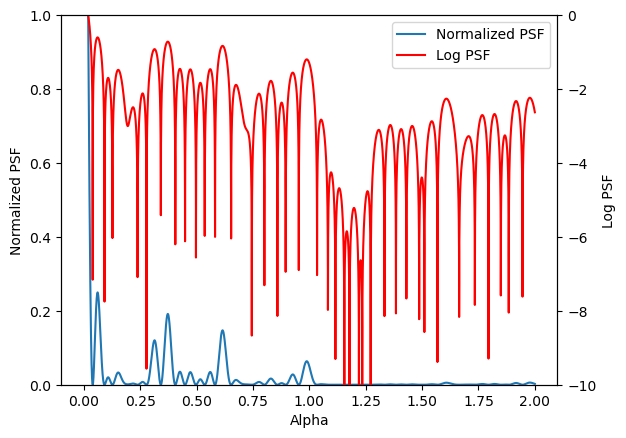

+-----+------------+-------------+--------------------+
|   k |        a_k |         u_k | u_k - u_{k-1}      |
+=====+============+=============+====================+
|   1 | 0.01679274 |  0.57678934 | -                  |
+-----+------------+-------------+--------------------+
|   2 | 0.00518818 |  1.59064381 | 1.0138544727784646 |
+-----+------------+-------------+--------------------+
|   3 | 0.00693626 |  2.55733074 | 0.9666869259597453 |
+-----+------------+-------------+--------------------+
|   4 | 0.14448633 |  3.56224552 | 1.0049147809515189 |
+-----+------------+-------------+--------------------+
|   5 | 0.06714870 |  4.57407372 | 1.0118281997613687 |
+-----+------------+-------------+--------------------+
|   6 | 0.00143610 |  5.56840910 | 0.9943353778198825 |
+-----+------------+-------------+--------------------+
|   7 | 0.03836798 |  6.54257650 | 0.9741674096066681 |
+-----+------------+-------------+--------------------+
|   8 | 0.08435028 |  7.59592320 | 1.05334669340

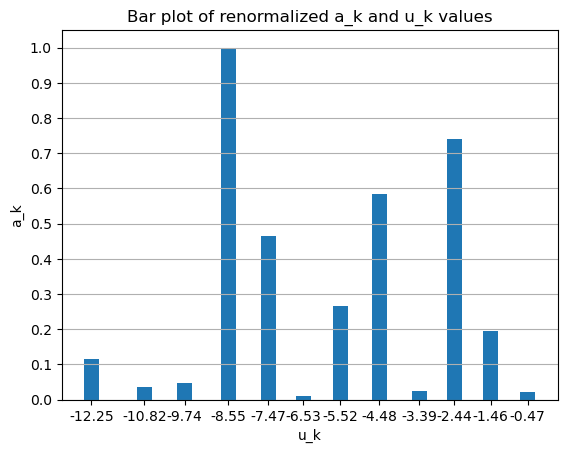

In [6]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import j1
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tabulate import tabulate

# Objective function
def objective(x, d, alpha_values):
    n = len(x) // 2
    a = x[:n]
    u = x[n:-1]
    t = x[-1]
    bessel_term = np.array([j1(np.pi * alpha) / alpha for alpha in alpha_values])
    sum_term = np.array([np.sum(a * np.cos(2 * np.pi * u[:, np.newaxis] / d * alpha)) for alpha in alpha_values])
    diff = bessel_term * sum_term - t
    return np.max(np.abs(diff))

# Constraints
def constraints(x, d, n):
    a = x[:n]
    u = x[n:-1]
    constraint_1 = [u[k+1] - u[k] - d for k in range(n-1)]
    constraint_2 = [np.sum(a) - 1]
    constraint_3 = [-a[k] for k in range(n)]
    return constraint_1 + constraint_2 + constraint_3

# Central flux computation
def central_flux(a, u, d, alpha_min, alpha_max):
    def psi(alpha):
        bessel_term = j1(np.pi * alpha) / alpha
        sum_term = np.sum(a * np.cos(2 * np.pi * u / d * alpha))
        return (bessel_term * sum_term)**2

    numerator, _ = quad(psi, 0, alpha_min)
    denominator, _ = quad(psi, 0, np.inf)
    return numerator / denominator

# Optimization
def optimize_psf(a_init, u_init, d, alpha_min, alpha_max, n, q):
    alpha_values = np.linspace(alpha_min, alpha_max, q)

    # Minimize the objective function
    x0 = np.concatenate((a_init, u_init, [0]))
    result = minimize(lambda x: objective(x, d, alpha_values),
                      x0=x0,
                      constraints={'type': 'ineq', 'fun': lambda x: constraints(x, d, n)},
                      tol=1e-10)
    return result

# Starting point strategy
def starting_point_strategy(m, d, alpha_min, alpha_max):
    n = 2 * m
    u_init = np.array([(k - 0.5) * d / (alpha_min + alpha_max) for k in range(1, m + 1)])
    u_init = np.concatenate((-u_init[::-1], u_init))

    a_init = np.ones(n)
    a_init /= np.sum(a_init)

    return a_init, u_init

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1

def normalized_psf(alpha, a, u, d):
    bessel_term = j1(np.pi * alpha) / alpha
    sum_term = np.sum(a * np.cos(2 * np.pi * u / d * alpha))
    return (bessel_term * sum_term)**2

def plot_psf(a_optimal, u_optimal, d):
    alpha_values = np.linspace(0.000001, 2, 10000)
    psf_values = [normalized_psf(alpha, a_optimal, u_optimal, d) for alpha in alpha_values]
    log_psf_values = np.log10(psf_values)

    fig, ax1 = plt.subplots()

    ax1.plot(alpha_values, psf_values, label='Normalized PSF')
    ax1.set_xlabel('Alpha')
    ax1.set_ylabel('Normalized PSF')
    ax1.set_ylim(0, 1)

    ax2 = ax1.twinx()
    ax2.plot(alpha_values, log_psf_values, 'r', label='Log PSF')
    ax2.set_ylabel('Log PSF')
    ax2.set_ylim(-10, 0)

    fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
    plt.show()

def print_table(a_values, u_values):
    k_values = range(1, len(a_values) + 1)
    u_diff_values = [u_values[i] - u_values[i - 1] for i in range(1, len(u_values))]
    u_diff_values.insert(0, "-")  # Add a dash for the first entry

    table_data = zip(k_values, a_values, u_values, u_diff_values)
    table_headers = ["k", "a_k", "u_k", "u_k - u_{k-1}"]

    print(tabulate(table_data, headers=table_headers, floatfmt=".8f", tablefmt="grid"))
    
def plot_bar_graph(a_optimal, u_optimal):
    # Renormalize a_k values
    a_optimal_renormalized = a_optimal / np.max(a_optimal)

    fig, ax = plt.subplots()
    bar_width = 0.4
    x = np.arange(1, len(a_optimal_renormalized) // 2 + 1)
    ax.bar(u_optimal[:len(u_optimal)//2], a_optimal_renormalized[:len(a_optimal_renormalized)//2], width=bar_width)
    ax.set_xlabel('u_k')
    ax.set_ylabel('a_k')
    ax.set_title('Bar plot of renormalized a_k and u_k values')
    plt.xticks(u_optimal[:len(u_optimal)//2], [f"{u:.2f}" for u in u_optimal[:len(u_optimal)//2]])
    plt.yticks(np.linspace(0, 1, 11))
    plt.grid(axis='y')
    plt.show()


def main():
    m = 12
    d = 1.0001
    alpha_min = 0.25
    alpha_max = 0.75
    n = 2 * m
    q = 10 * n

    a_init, u_init = starting_point_strategy(m, d, alpha_min, alpha_max)

    result = optimize_psf(a_init, u_init, d, alpha_min, alpha_max, n, q)
    x_optimal = result.x
    a_optimal = x_optimal[:n]
    u_optimal = x_optimal[n:-1]
    
     # Considering only the second half of u_k values and sorting them in ascending order
    u_optimal_positive = np.sort(u_optimal[m:])
    
    # Considering only the second half of a_k values
    a_optimal_positive = a_optimal[m:]



    dynamic = 1 / result.fun
    central_flux_value = central_flux(a_optimal, u_optimal, d, alpha_min, alpha_max)

    print("Optimal values of a_k:", a_optimal)
    print("Optimal values of u_k:", u_optimal)
    print("Dynamic:", dynamic)
    print("Central flux:", central_flux_value)
    plot_psf(a_optimal, u_optimal, d)
    print_table(a_optimal[:12], u_optimal[12:])
    plot_bar_graph(a_optimal, u_optimal)


if __name__ == "__main__":
    main()


# 7th case => m=12  (24 Pupils) and [alpha_min,alpha_max]=[0.09,0.83]

/var/folders/qc/cl66n0gn1cqgckzb18klf0zw0000gn/T/ipykernel_63703/3384682904.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  denominator, _ = quad(psi, 0, np.inf)


Optimal values of a_k: [0.05171413 0.03814665 0.04833863 0.03880308 0.03690253 0.04815052
 0.04016829 0.02379962 0.05114048 0.04181948 0.03788418 0.027051
 0.03254483 0.03446532 0.04299539 0.03878107 0.0486963  0.03986894
 0.04588814 0.0368111  0.05123197 0.03468075 0.02820741 0.03472951]
Optimal values of u_k: [-13.24838918 -12.07404131 -11.02815114 -10.07791694  -8.57492737
  -7.38518209  -6.19071791  -5.16205506  -4.13172609  -3.06129944
  -1.61976448  -0.59943843   0.4742667    1.73870735   2.74456278
   3.86127748   4.93611056   6.38400063   7.49805633   8.70075424
   9.98408197  10.94628129  12.02054494  15.38508499]
Dynamic: 0.32492881183551464
Central flux: 0.8089805497316278


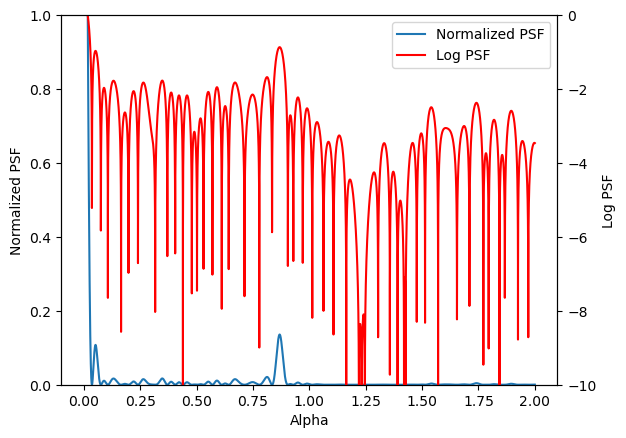

+-----+------------+-------------+--------------------+
|   k |        a_k |         u_k | u_k - u_{k-1}      |
+=====+============+=============+====================+
|   1 | 0.05171413 |  0.47426670 | -                  |
+-----+------------+-------------+--------------------+
|   2 | 0.03814665 |  1.73870735 | 1.2644406543067237 |
+-----+------------+-------------+--------------------+
|   3 | 0.04833863 |  2.74456278 | 1.0058554248279175 |
+-----+------------+-------------+--------------------+
|   4 | 0.03880308 |  3.86127748 | 1.116714706084506  |
+-----+------------+-------------+--------------------+
|   5 | 0.03690253 |  4.93611056 | 1.0748330788574476 |
+-----+------------+-------------+--------------------+
|   6 | 0.04815052 |  6.38400063 | 1.4478900663186485 |
+-----+------------+-------------+--------------------+
|   7 | 0.04016829 |  7.49805633 | 1.114055701639166  |
+-----+------------+-------------+--------------------+
|   8 | 0.02379962 |  8.70075424 | 1.20269790969

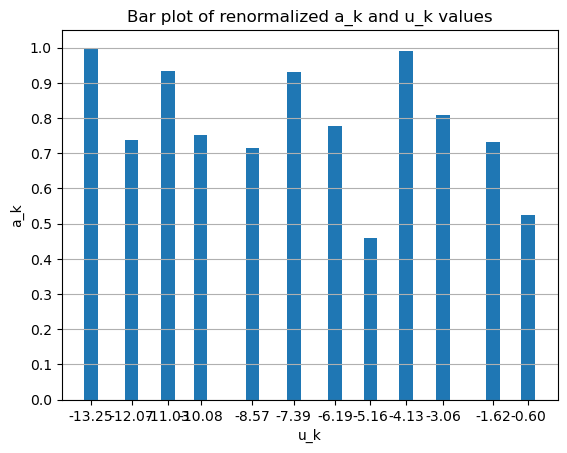

In [7]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import j1
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tabulate import tabulate

# Objective function
def objective(x, d, alpha_values):
    n = len(x) // 2
    a = x[:n]
    u = x[n:-1]
    t = x[-1]
    bessel_term = np.array([j1(np.pi * alpha) / alpha for alpha in alpha_values])
    sum_term = np.array([np.sum(a * np.cos(2 * np.pi * u[:, np.newaxis] / d * alpha)) for alpha in alpha_values])
    diff = bessel_term * sum_term - t
    return np.max(np.abs(diff))

# Constraints
def constraints(x, d, n):
    a = x[:n]
    u = x[n:-1]
    constraint_1 = [u[k+1] - u[k] - d for k in range(n-1)]
    constraint_2 = [np.sum(a) - 1]
    constraint_3 = [-a[k] for k in range(n)]
    return constraint_1 + constraint_2 + constraint_3

# Central flux computation
def central_flux(a, u, d, alpha_min, alpha_max):
    def psi(alpha):
        bessel_term = j1(np.pi * alpha) / alpha
        sum_term = np.sum(a * np.cos(2 * np.pi * u / d * alpha))
        return (bessel_term * sum_term)**2

    numerator, _ = quad(psi, 0, alpha_min)
    denominator, _ = quad(psi, 0, np.inf)
    return numerator / denominator

# Optimization
def optimize_psf(a_init, u_init, d, alpha_min, alpha_max, n, q):
    alpha_values = np.linspace(alpha_min, alpha_max, q)

    # Minimize the objective function
    x0 = np.concatenate((a_init, u_init, [0]))
    result = minimize(lambda x: objective(x, d, alpha_values),
                      x0=x0,
                      constraints={'type': 'ineq', 'fun': lambda x: constraints(x, d, n)},
                      tol=1e-10)
    return result

# Starting point strategy
def starting_point_strategy(m, d, alpha_min, alpha_max):
    n = 2 * m
    u_init = np.array([(k - 0.5) * d / (alpha_min + alpha_max) for k in range(1, m + 1)])
    u_init = np.concatenate((-u_init[::-1], u_init))

    a_init = np.ones(n)
    a_init /= np.sum(a_init)

    return a_init, u_init

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1

def normalized_psf(alpha, a, u, d):
    bessel_term = j1(np.pi * alpha) / alpha
    sum_term = np.sum(a * np.cos(2 * np.pi * u / d * alpha))
    return (bessel_term * sum_term)**2

def plot_psf(a_optimal, u_optimal, d):
    alpha_values = np.linspace(0.000001, 2, 10000)
    psf_values = [normalized_psf(alpha, a_optimal, u_optimal, d) for alpha in alpha_values]
    log_psf_values = np.log10(psf_values)

    fig, ax1 = plt.subplots()

    ax1.plot(alpha_values, psf_values, label='Normalized PSF')
    ax1.set_xlabel('Alpha')
    ax1.set_ylabel('Normalized PSF')
    ax1.set_ylim(0, 1)

    ax2 = ax1.twinx()
    ax2.plot(alpha_values, log_psf_values, 'r', label='Log PSF')
    ax2.set_ylabel('Log PSF')
    ax2.set_ylim(-10, 0)

    fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
    plt.show()

def print_table(a_values, u_values):
    k_values = range(1, len(a_values) + 1)
    u_diff_values = [u_values[i] - u_values[i - 1] for i in range(1, len(u_values))]
    u_diff_values.insert(0, "-")  # Add a dash for the first entry

    table_data = zip(k_values, a_values, u_values, u_diff_values)
    table_headers = ["k", "a_k", "u_k", "u_k - u_{k-1}"]

    print(tabulate(table_data, headers=table_headers, floatfmt=".8f", tablefmt="grid"))
    
def plot_bar_graph(a_optimal, u_optimal):
    # Renormalize a_k values
    a_optimal_renormalized = a_optimal / np.max(a_optimal)

    fig, ax = plt.subplots()
    bar_width = 0.4
    x = np.arange(1, len(a_optimal_renormalized) // 2 + 1)
    ax.bar(u_optimal[:len(u_optimal)//2], a_optimal_renormalized[:len(a_optimal_renormalized)//2], width=bar_width)
    ax.set_xlabel('u_k')
    ax.set_ylabel('a_k')
    ax.set_title('Bar plot of renormalized a_k and u_k values')
    plt.xticks(u_optimal[:len(u_optimal)//2], [f"{u:.2f}" for u in u_optimal[:len(u_optimal)//2]])
    plt.yticks(np.linspace(0, 1, 11))
    plt.grid(axis='y')
    plt.show()


def main():
    m = 12
    d = 1.001
    alpha_min = 0.09
    alpha_max = 0.83
    n = 2 * m
    q = 10 * n

    a_init, u_init = starting_point_strategy(m, d, alpha_min, alpha_max)

    result = optimize_psf(a_init, u_init, d, alpha_min, alpha_max, n, q)
    x_optimal = result.x
    a_optimal = x_optimal[:n]
    u_optimal = x_optimal[n:-1]
    
     # Considering only the second half of u_k values and sorting them in ascending order
    u_optimal_positive = np.sort(u_optimal[m:])
    
    # Considering only the second half of a_k values
    a_optimal_positive = a_optimal[m:]



    dynamic = 1 / result.fun
    central_flux_value = central_flux(a_optimal, u_optimal, d, alpha_min, alpha_max)

    print("Optimal values of a_k:", a_optimal)
    print("Optimal values of u_k:", u_optimal)
    print("Dynamic:", dynamic)
    print("Central flux:", central_flux_value)
    plot_psf(a_optimal, u_optimal, d)
    print_table(a_optimal[:12], u_optimal[12:])
    plot_bar_graph(a_optimal, u_optimal)


if __name__ == "__main__":
    main()
